In [1]:
import numpy as np
import moviepy.editor as mp
import opensmile
import pandas as pd
import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import matplotlib
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import svm #Import svm model
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score,classification_report
import joblib

In [2]:
hindidatafilepath = r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\data\\trimmed_hindi\\"
hindidatafilepathwav = r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\data\\trimmed_hindi_wav\\"
speakerID =  os.listdir(hindidatafilepath) #stores the speaker IDs

In [3]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

In [4]:
file_attitude = []
file_activation = [] #activation based classification
file_valence = [] #valence based classification
file_dominance = [] #dominance based classification
file_path = []
sentence_identity = []
speaker_identity = []
for fileDir in speakerID:
    for file in os.listdir(hindidatafilepathwav + fileDir+"\\"):
        file_path.append("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav\\"+fileDir+"\\"+file[:-4]+".wav")
        file_attitude.append(file[10:14]) #label of attitude 4 letter symbol
        sentence_identity.append(file[15]) #sentence labels could be 'a' and 'b'
        speaker_identity.append(file[0:3])
        #getting the activations based on attitudes from each utterance 3 (+1 - high, 0 - moderate, -1 - low)
        if file[10:14].lower() in ["admi", "surp", "arro", "cont", "irri"]:
            file_activation.append(1)#denotes high activation
        elif file[10:14].lower() in ["iron" , "sedu" , "auth" , "doub" , "unce"]:
            file_activation.append(0)
        else:
            file_activation.append(-1)

        if file[10:14].lower() in ["admi" , "surp", "sedu"]:
            file_valence.append("pos")
        elif file[10:14].lower() in ["decl", "ques", "poli", "sinc", "woeg"]:
            file_valence.append("neu")
        elif file[10:14].lower() in ["iron", "auth", "doub", "obvi"]:
            file_valence.append("mix")
        else:
            file_valence.append("neg")

        #dominance based classification
        if file[10:14].lower() in ["auth", "arro", "cont"]:
            file_dominance.append(1)
        elif file[10:14].lower() in ["poli", "decl", "ques", "sinc", "unce", "woeg"]:
            file_dominance.append(-1)
        else:
            file_dominance.append(0)


In [5]:
data, sampling_rate = librosa.load(file_path[0])
max_length = len(data)
df = smile.process_signal(
    data,
    sampling_rate
)
for audioFile in file_path[1:]: 
  data, sampling_rate = librosa.load(audioFile)
  if len(data)>= max_length:#finding maximum length across all the utterances
    max_length = len(data)
  df = pd.concat([df, smile.process_signal(
    data,
    sampling_rate
)])

In [6]:
X = df.to_numpy() #no_of_samples x 88...no_of_samples = 512, 8 speakers, each has 16 attitudes and 2 sentences spoken twice per attitude

In [11]:
class StandardScaleNormalizer():

    def fit(self, X, speaker):
        """Fits the normalization on input data wrt each of the speaker

        Args:
            X (_type_): _description_
            y_attitude (_type_): _description_
            speaker (_type_): _description_
        """
        speakerID = set(speaker) #generates the unique speaker IDs
        dictMean, dictStd = {}, {}
        df = pd.DataFrame(X)
        df["speakerID"]=speaker
        for id in speakerID:
            df_speaker = df.loc[df["speakerID"] == id]
            df_speaker = df_speaker.drop(["speakerID"], axis = 1)
            dictMean[id] = df_speaker.mean()
            dictStd[id] = df_speaker.std()
            
        self.mean = dictMean
        self.scale = dictStd
        
    def transform(self, X, speaker):
        speakerID = set(speaker) #generates the unique speaker IDs
        df = pd.DataFrame(X)
        df["speakerID"]=speaker
        df_copy = df.copy()
        for id in speakerID:
            df_copy.loc[df_copy["speakerID"] == id] = (df_copy.loc[df_copy["speakerID"] == id]-self.mean[id])/self.scale[id]
        return df_copy.drop(["speakerID"], axis=1)

    def fit_transform(self, X, speaker):
        self.fit(X, speaker)
        df_copy = self.transform(X, speaker)
        return df_copy


In [12]:
normModel = StandardScaleNormalizer()
Xnorm = normModel.fit_transform(X, speaker_identity)

In [58]:
trained_savee_model_ensemble = []
model_path = r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\models\\savee\\"
for i in os.listdir(model_path):
    print("Loading model with {spk} left out in SAVEE".format(spk=i[-6:-4]))
    trained_savee_model_ensemble.append(joblib.load(model_path+i))

Loading model with DC left out in SAVEE
Loading model with JE left out in SAVEE
Loading model with JK left out in SAVEE
Loading model with KL left out in SAVEE


In [13]:
trained_savee_model_ensemble[0].predict(Xnorm)

array(['fear', 'neutral', 'angry', 'fear', 'disgust', 'angry', 'angry',
       'angry', 'disgust', 'angry', 'disgust', 'angry', 'sad', 'fear',
       'fear', 'disgust', 'disgust', 'neutral', 'neutral', 'disgust',
       'fear', 'fear', 'surprise', 'fear', 'happy', 'angry', 'disgust',
       'disgust', 'angry', 'angry', 'angry', 'surprise', 'fear', 'fear',
       'fear', 'disgust', 'neutral', 'angry', 'disgust', 'disgust',
       'surprise', 'fear', 'disgust', 'fear', 'disgust', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'fear', 'disgust',
       'surprise', 'surprise', 'surprise', 'fear', 'sad', 'disgust',
       'disgust', 'neutral', 'neutral', 'disgust', 'sad', 'neutral',
       'neutral', 'sad', 'fear', 'happy', 'angry', 'angry', 'happy',
       'fear', 'angry', 'angry', 'angry', 'happy', 'sad', 'angry',
       'disgust', 'disgust', 'neutral', 'neutral', 'neutral', 'disgust',
       'happy', 'angry', 'happy', 'surprise', 'sad', 'angry', 'disgust',
       'happy', 

<AxesSubplot:>

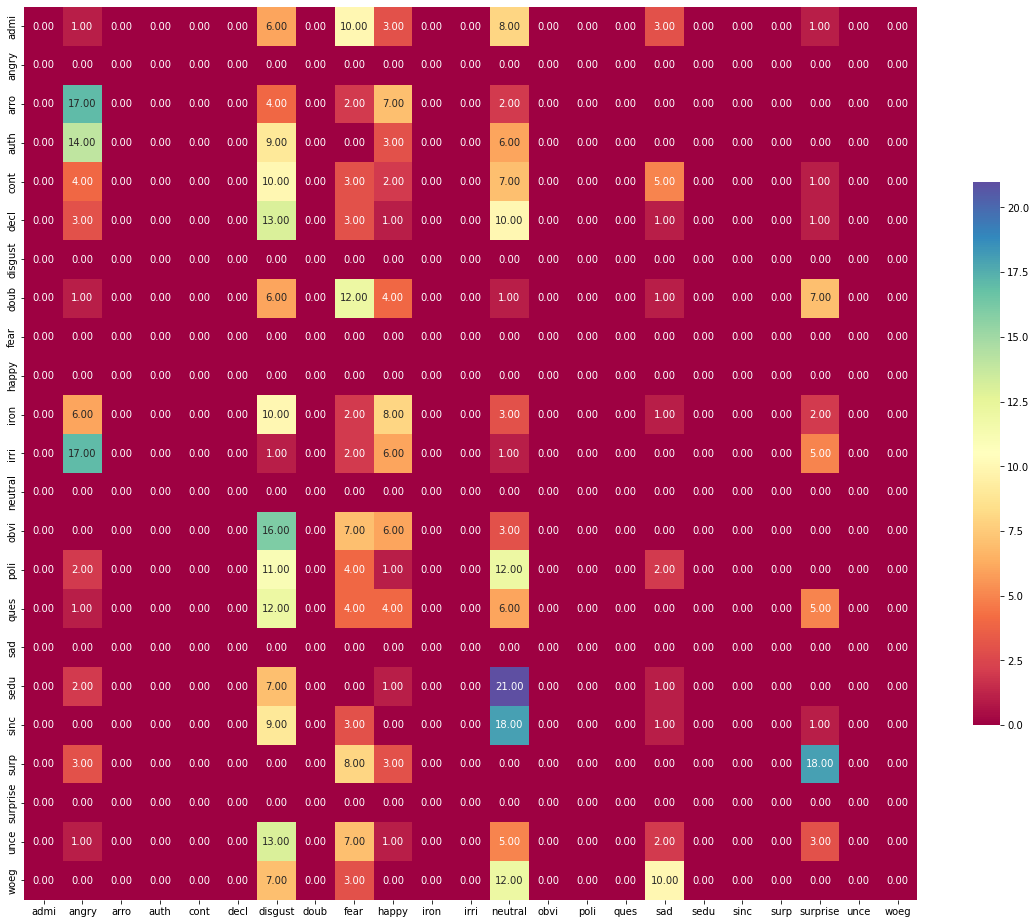

In [26]:
cm = confusion_matrix(file_attitude, trained_savee_model_ensemble[0].predict(Xnorm))
kk = np.sort(list(set(file_attitude)) + list(set(trained_savee_model_ensemble[0].predict(Xnorm))))
plt.figure(figsize=(20,20))

sns.heatmap(cm, cmap = 'Spectral',cbar_kws={"shrink": 0.5},square= True,annot=True, fmt='.2f', xticklabels=kk, yticklabels=kk)

In [31]:
df_labels = pd.DataFrame()
df_labels["SAVEE Labels"] = file_attitude
for i in range(len(trained_savee_model_ensemble)):
    df_labels[f"Pred{i}"] = trained_savee_model_ensemble[i].predict(Xnorm)
df_final_please_god_im_done  = pd.crosstab(df_labels['SAVEE Labels'], df_labels['Pred0'])
for i in range(1, len(trained_savee_model_ensemble)):
    df_final_please_god_im_done += pd.crosstab(df_labels['SAVEE Labels'], df_labels[f'Pred{i}'])

In [32]:
df_final_please_god_im_done

Pred0,angry,disgust,fear,happy,neutral,sad,surprise
SAVEE Labels,,,,,,,
admi,10,27,33,13,18,18,9
arro,67,16,9,25,10,0,1
auth,55,35,4,16,17,0,1
cont,21,39,10,7,25,24,2
decl,11,56,10,3,31,16,1
doub,6,23,28,18,4,4,45
iron,26,42,6,30,11,5,8
irri,61,4,14,38,3,0,8
obvi,7,64,22,21,7,0,7


In [41]:
df_final_please_god_im_done.sum(axis=1)

SAVEE Labels
admi    128
arro    128
auth    128
cont    128
decl    128
doub    128
iron    128
irri    128
obvi    128
poli    128
ques    128
sedu    128
sinc    128
surp    128
unce    128
woeg    128
dtype: int64

<AxesSubplot:xlabel='Pred0', ylabel='SAVEE Labels'>

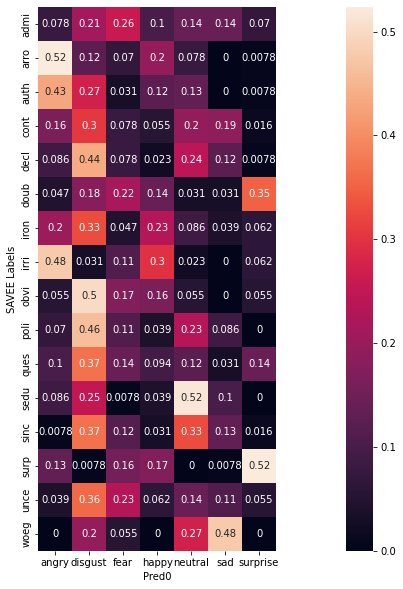

In [55]:
plt.figure(figsize=(25,10))
sns.heatmap(df_final_please_god_im_done/df_final_please_god_im_done.sum(axis=1)[:, np.newaxis],square= True, annot=True)

In [68]:
prob_sum = trained_savee_model_ensemble[0].predict_proba(Xnorm)
for i in range(1, 4):
    prob_sum+=trained_savee_model_ensemble[i].predict_proba(Xnorm)
prob_sum /=4.0

In [76]:
labels = np.sort(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
predictions = [labels[i] for i in np.argmax(prob_sum, axis=1)]

In [80]:
df_labels_new = pd.DataFrame()
df_labels_new["SAVEE Labels"] = file_attitude
df_labels_new["pred"] = predictions
df_labels_new_god_im_done_please_son_of_holyness = pd.crosstab(df_labels_new['SAVEE Labels'], df_labels_new['pred'])

<AxesSubplot:xlabel='pred', ylabel='SAVEE Labels'>

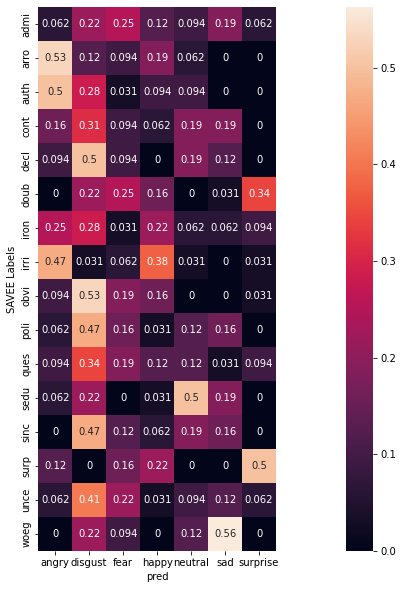

In [81]:
plt.figure(figsize=(25,10))
sns.heatmap(df_labels_new_god_im_done_please_son_of_holyness/df_labels_new_god_im_done_please_son_of_holyness.sum(axis=1)[:, np.newaxis],square= True, annot=True)